# 1. Prerequisites

**Recommendation:** We recommend to download this Notebook and run it using Google Colab.

## 1.1. Python Libraries Installation

The following step will install the required Python libraries, and the rest of the cells in this Notebook will help you go through the pipeline step by step:

- **Numpy and Pandas:** for data manipulation and analysis.
- **Matplotlib and Seaborn:** for data visualization.
- **Nilearn:** to facilitate the processing and visualization of neuroimaging data.
- **IPython:** for interactive computing, providing an enhanced interactive shell and support for Jupyter notebooks.
- **Scikit-learn:** for machine learning, providing tools for data analysis, metrics and building predictive models.
- **XGBoost** for implementing optimized gradient boosting algorithms, which are highly effective for supervised learning tasks such as classification and regression.


In [1]:
!pip install numpy pandas matplotlib seaborn nilearn ipython scikit-learn xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 29.6 MB/s eta 0:00:00


## 1.2. Environment Setup

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


## 1.3. Clone the repo

In [4]:
!git clone https://github.com/AgustinNR/BrainHack-BsAs-Humai-Team1

Cloning into 'BrainHack-BsAs-Humai-Team1'...
remote: Enumerating objects: 1352, done.
remote: Counting objects: 100% (405/405), done.
remote: Compressing objects: 100% (208/208), done.
remote: Total 1352 (delta 197), reused 393 (delta 187), pack-reused 947
Receiving objects: 100% (1352/1352), 80.30 MiB | 12.23 MiB/s, done.
Resolving deltas: 100% (655/655), done.


## 1.4. Download the Data

In [5]:
%cd /content/drive/MyDrive/BrainHack-BsAs-Humai-Team1/process


/content/drive/MyDrive/BrainHack-BsAs-Humai-Team1/process


In [6]:
%%python download_abide_preproc.py -d rois_aal -p ccs -s nofilt_noglobal -o /content/drive/MyDrive/BrainHack-BsAs-Humai-Team1/data/preprocessed

No upper age threshold specified
No lower age threshold specified
No site specified, using all sites...
No sex specified, using all sexes...
b',Unnamed: 0,SUB_ID,X,subject,SITE_ID,FILE_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,SEX,HANDEDNESS_CATEGORY,HANDEDNESS_SCORES,FIQ,VIQ,PIQ,FIQ_TEST_TYPE,VIQ_TEST_TYPE,PIQ_TEST_TYPE,ADI_R_SOCIAL_TOTAL_A,ADI_R_VERBAL_TOTAL_BV,ADI_RRB_TOTAL_C,ADI_R_ONSET_TOTAL_D,ADI_R_RSRCH_RELIABLE,ADOS_MODULE,ADOS_TOTAL,ADOS_COMM,ADOS_SOCIAL,ADOS_STEREO_BEHAV,ADOS_RSRCH_RELIABLE,ADOS_GOTHAM_SOCAFFECT,ADOS_GOTHAM_RRB,ADOS_GOTHAM_TOTAL,ADOS_GOTHAM_SEVERITY,SRS_VERSION,SRS_RAW_TOTAL,SRS_AWARENESS,SRS_COGNITION,SRS_COMMUNICATION,SRS_MOTIVATION,SRS_MANNERISMS,SCQ_TOTAL,AQ_TOTAL,COMORBIDITY,CURRENT_MED_STATUS,MEDICATION_NAME,OFF_STIMULANTS_AT_SCAN,VINELAND_RECEPTIVE_V_SCALED,VINELAND_EXPRESSIVE_V_SCALED,VINELAND_WRITTEN_V_SCALED,VINELAND_COMMUNICATION_STANDARD,VINELAND_PERSONAL_V_SCALED,VINELAND_DOMESTIC_V_SCALED,VINELAND_COMMUNITY_V_SCALED,VINELAND_DAILYLVNG_STANDARD,VINELAND_

## 1.5. Import the Python Libraries

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
from nilearn import datasets
from nilearn import plotting
from IPython.display import display
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report

# 2. First Approach to the Dataset

## 2.1. Data Loading for One Subject

We established the file path using the os library and loaded the downloaded ".1D" files using numpy.

In [18]:
current_folder = os.path.abspath('.')
data_folder = "/content/drive/MyDrive/BrainHack-BsAs-Humai-Team1/data/preprocessed/Outputs/ccs/nofilt_noglobal/rois_aal"

parent_folder = "/content/drive/MyDrive/BrainHack-BsAs-Humai-Team1"

# Relative path to the .1D file:
relative_path = r'Caltech_0051456_rois_aal.1D'
print(relative_path)
# Full path build using os.path.join:
file_path = os.path.join(data_folder, relative_path)
print(file_path)
# Time series data extraction using Numpy:
time_series_data = np.loadtxt(file_path)

# Display the shape of the loaded data
print("Shape of the loaded data array:", time_series_data.shape)

Caltech_0051456_rois_aal.1D
/content/drive/MyDrive/BrainHack-BsAs-Humai-Team1/data/preprocessed/Outputs/ccs/nofilt_noglobal/rois_aal/Caltech_0051456_rois_aal.1D
Shape of the loaded data array: (145, 116)


## 2.2. Visualize the Data of One Subject
We can visualize the rs-fMRI signal of on subject to get an initial understanding of the data.

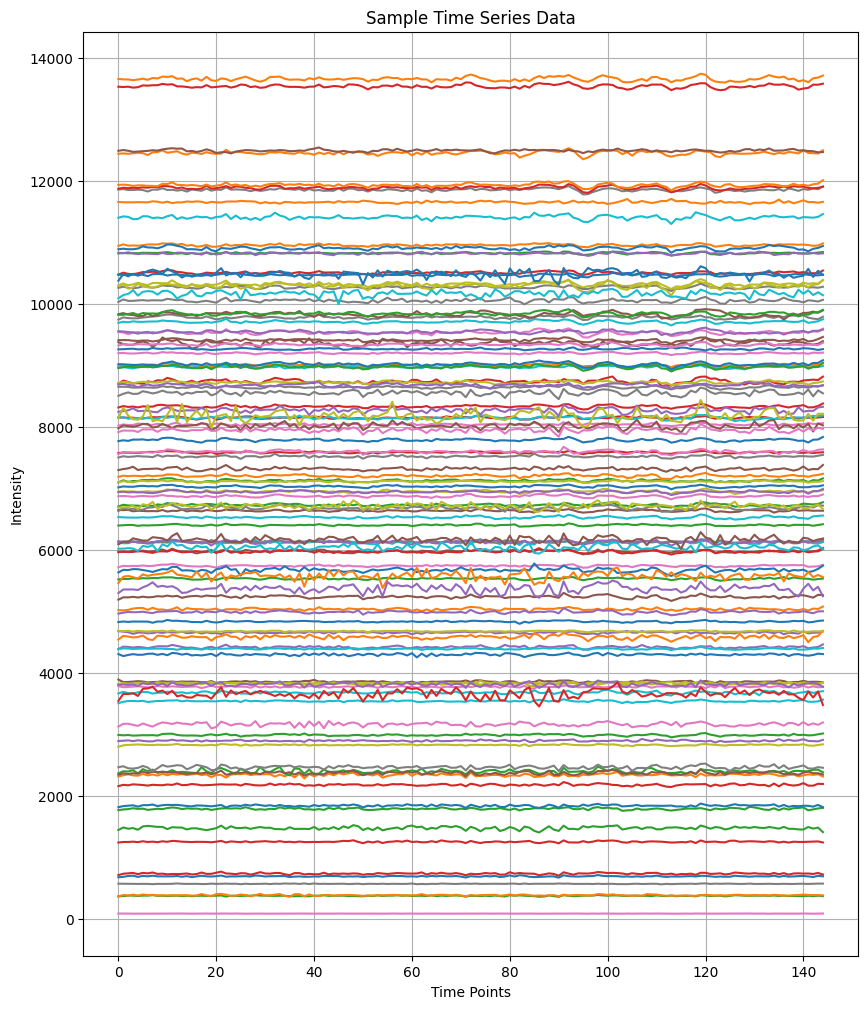

In [10]:
# Plotting the time series data for one subject
plt.figure(figsize=(10, 12))
plt.plot(time_series_data)
plt.xlabel('Time Points')
plt.ylabel('Intensity')
plt.title('Sample Time Series Data')
plt.grid(True)
plt.show()

A closer sight:

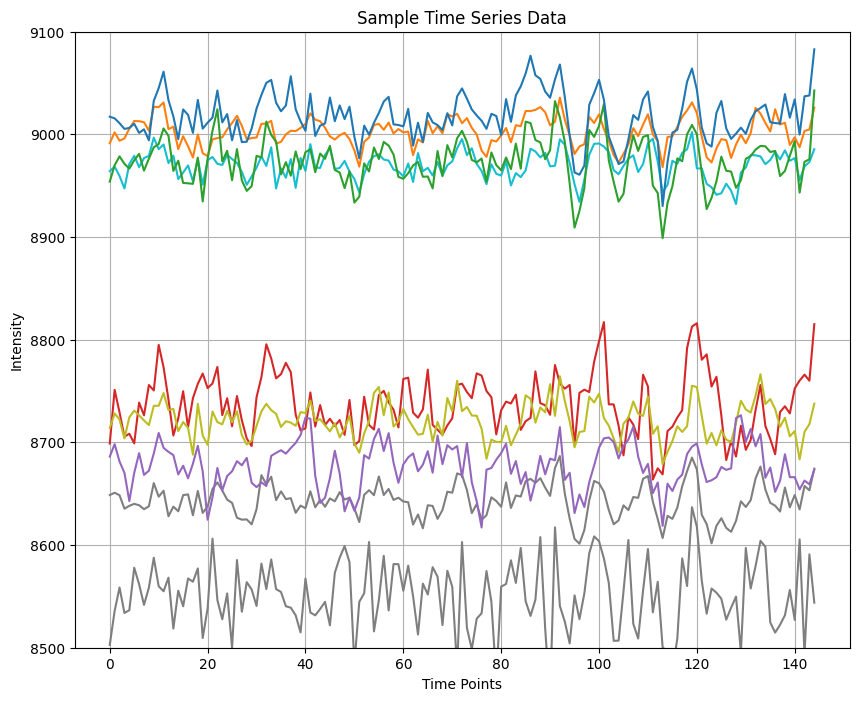

In [11]:
plt.figure(figsize=(10, 8))
plt.plot(time_series_data)
plt.ylim(8500,9100)

plt.xlabel('Time Points')
plt.ylabel('Intensity')
plt.title('Sample Time Series Data')
plt.grid(True)
plt.show()

## 2.3. Brain Parcelation: AAL Atlas


Added README.md to /root/nilearn_data


Dataset created in /root/nilearn_data/aal_SPM12



 ...done. (2 seconds, 0 min)
Extracting data from /root/nilearn_data/aal_SPM12/a4f2a6316ec7f29f771edef840308edf/aal_for_SPM12.tar.gz..... done.


116
Atlas labels: ['Precentral_L', 'Precentral_R', 'Frontal_Sup_L', 'Frontal_Sup_R', 'Frontal_Sup_Orb_L', 'Frontal_Sup_Orb_R', 'Frontal_Mid_L', 'Frontal_Mid_R', 'Frontal_Mid_Orb_L', 'Frontal_Mid_Orb_R', 'Frontal_Inf_Oper_L', 'Frontal_Inf_Oper_R', 'Frontal_Inf_Tri_L', 'Frontal_Inf_Tri_R', 'Frontal_Inf_Orb_L', 'Frontal_Inf_Orb_R', 'Rolandic_Oper_L', 'Rolandic_Oper_R', 'Supp_Motor_Area_L', 'Supp_Motor_Area_R', 'Olfactory_L', 'Olfactory_R', 'Frontal_Sup_Medial_L', 'Frontal_Sup_Medial_R', 'Frontal_Med_Orb_L', 'Frontal_Med_Orb_R', 'Rectus_L', 'Rectus_R', 'Insula_L', 'Insula_R', 'Cingulum_Ant_L', 'Cingulum_Ant_R', 'Cingulum_Mid_L', 'Cingulum_Mid_R', 'Cingulum_Post_L', 'Cingulum_Post_R', 'Hippocampus_L', 'Hippocampus_R', 'ParaHippocampal_L', 'ParaHippocampal_R', 'Amygdala_L', 'Amygdala_R', 'Calcarine_L', 'Calcarine_R', 'Cuneus_L', 'Cuneus_R', 'Lingual_L', 'Lingual_R', 'Occipital_Sup_L', 'Occipital_Sup_R', 'Occipital_Mid_L', 'Occipital_Mid_R', 'Occipital_Inf_L', 'Occipital_Inf_R', 'Fusiform_L',

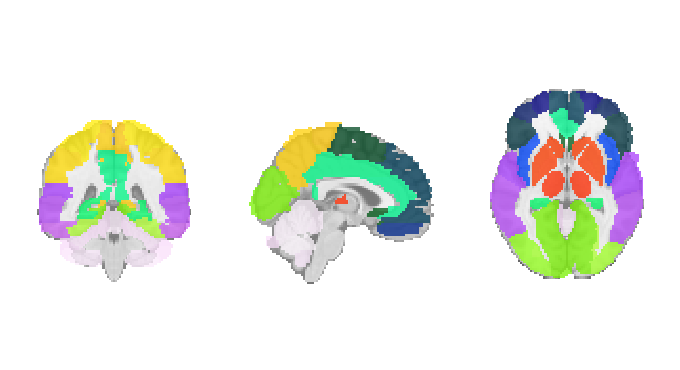

In [12]:
# Load the atlas
atlas = datasets.fetch_atlas_aal()
atlas_filename = atlas.maps
atlas_labels = atlas.labels
atlas_indices = atlas.indices
atlas_description = atlas.description
plotting.plot_roi(atlas_filename, draw_cross=False, annotate=False, alpha=0.75)

print(len(atlas_labels))
print("Atlas labels:", atlas_labels)

## 2.4. Connectivity Matrix: Individual Correlation Matrix

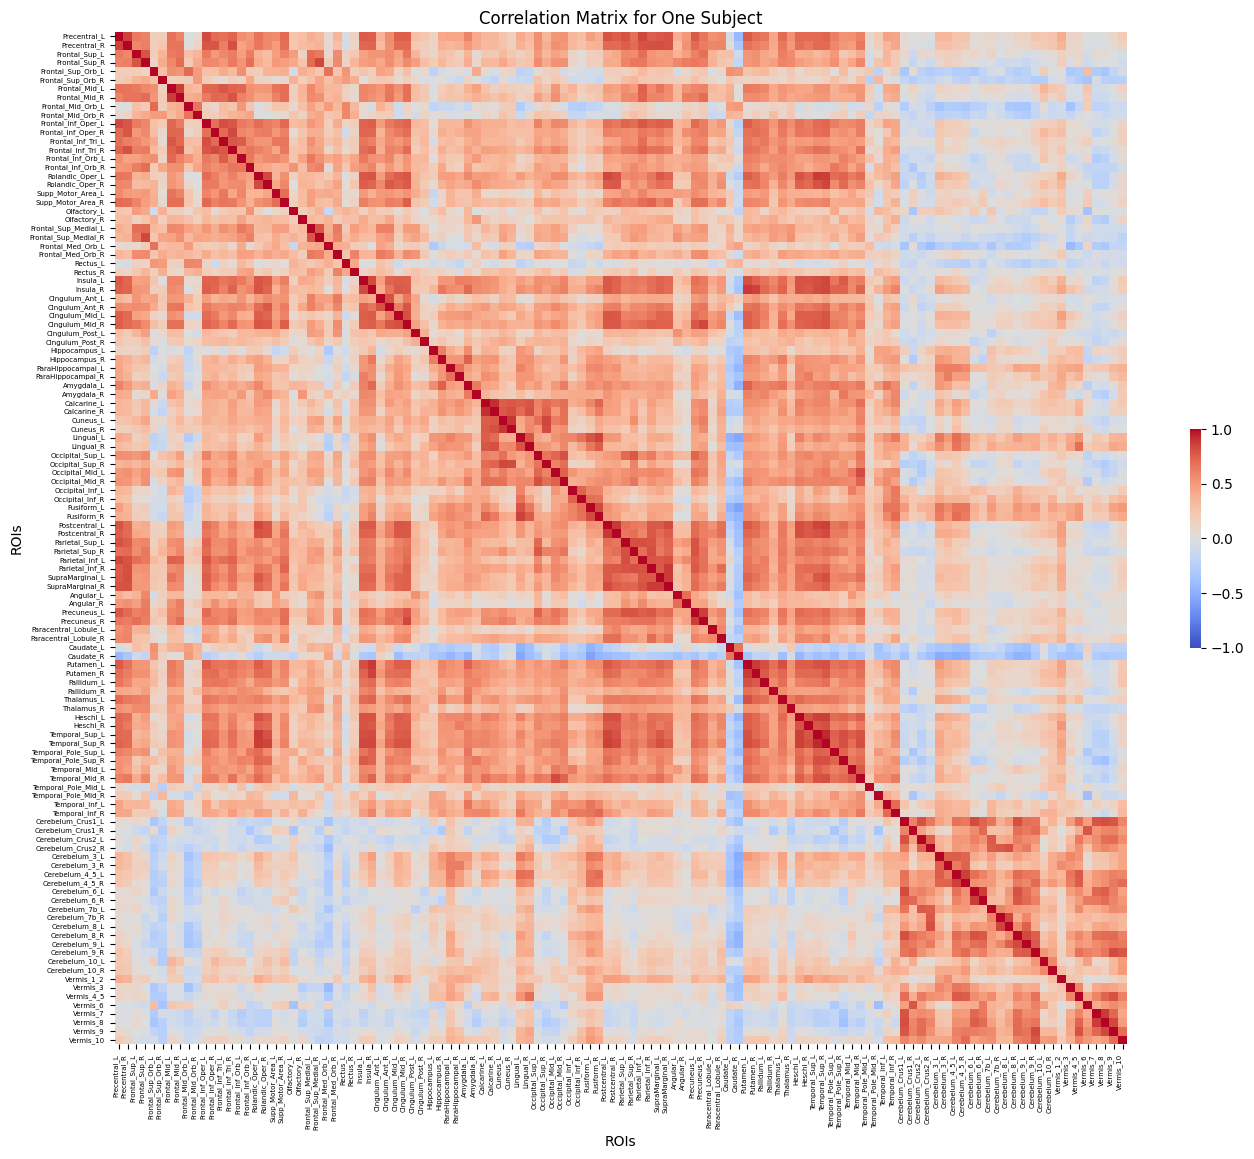

In [13]:
# Calculate the correlation matrix
correlation_matrix = np.corrcoef(time_series_data.T)  # Transposed so that rows represent different ROIs

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(14, 12))
heatmap = sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1, xticklabels=atlas_labels, yticklabels=atlas_labels, square=True, cbar_kws={"shrink": .2})
plt.title('Correlation Matrix for One Subject')
plt.xlabel('ROIs')
plt.ylabel('ROIs')
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=90, ha='right', fontsize=5)
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0, fontsize=5)
plt.tight_layout()
plt.show()

## 2.5. Cleaning the Individual Correlation Matrix

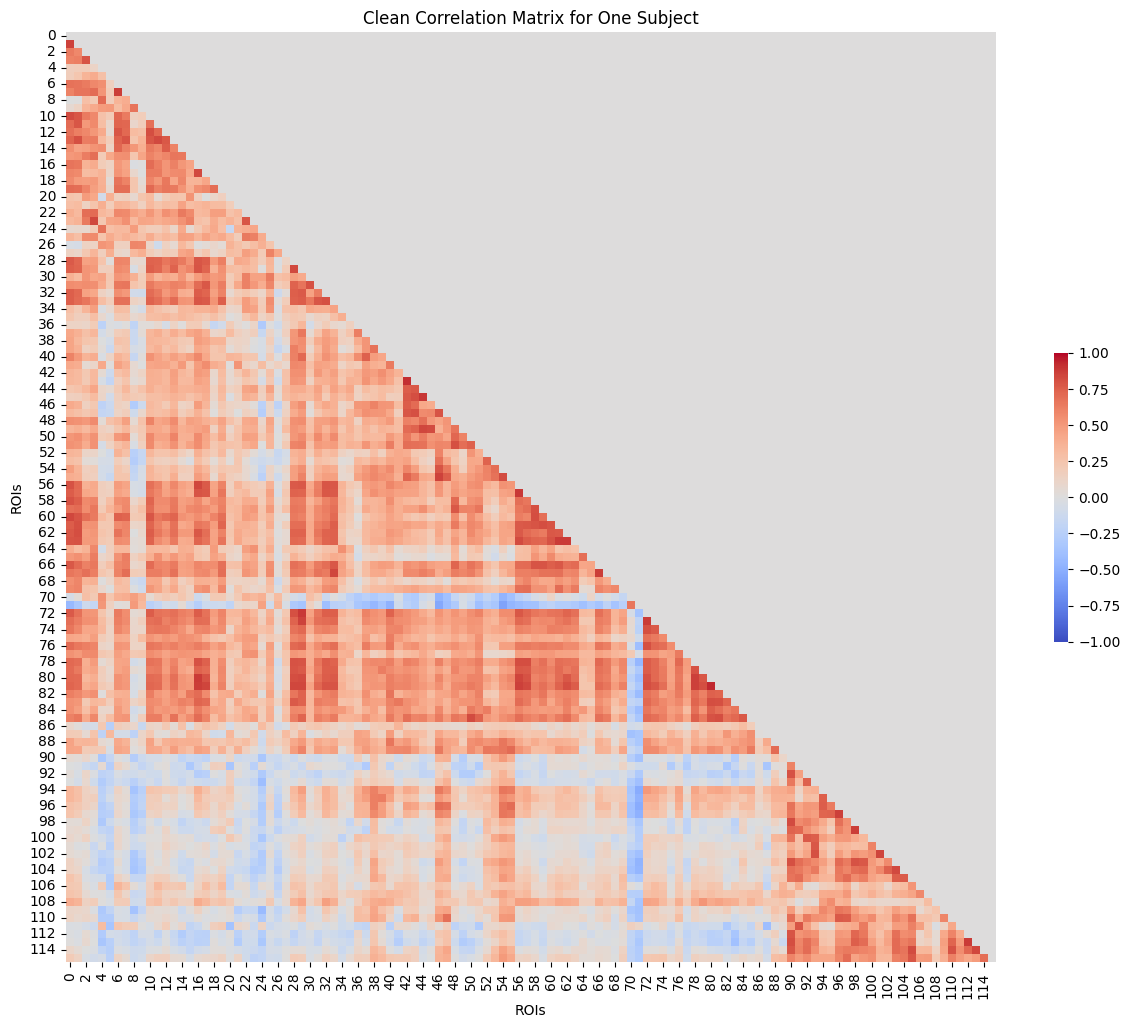

In [14]:
#Plotting just the lower triangule of the correlation matrix:
lower_triangle = np.tril(correlation_matrix, k=-1)

plt.figure(figsize=(15, 15))
sns.heatmap(lower_triangle, annot=False, cmap='coolwarm', vmin=-1, vmax=1,  cbar_kws={"shrink": .25}, square=True)
plt.title('Clean Correlation Matrix for One Subject')
plt.xlabel('ROIs')
plt.ylabel('ROIs')
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=90, fontsize=2)
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0, fontsize=2)
plt.show()

## 2.6. Vectorizing the Cleaned Individual Correlation Matrix

#### This method is ordered rows-wise from the lower triangular matrix. Specifically, the order follows:

- All elements from the first row below the diagonal.
- All elements from the second row below the diagonal.
- And so on, up to the last row.

In [15]:
lower_triangle_indices = np.tril_indices(correlation_matrix.shape[0], k=-1)

vectorized_lower_triangle = lower_triangle[lower_triangle_indices]

print("Vector with the elements of the lower half of the one subject correlation matrix (without the diagonal):\n", vectorized_lower_triangle)


Vector with the elements of the lower half of the one subject correlation matrix (without the diagonal):
 [0.8551459  0.63654572 0.58432355 ... 0.4270709  0.48446456 0.69084218]


## 2.7. Checking the Quality of the Vector

In [16]:
vector = vectorized_lower_triangle
print(f"Data type: {vector.dtype}")
print(f"Min value: {np.min(vector)}")
print(f"Max value: {np.max(vector)}")
print(f"Mean value: {np.mean(vector)}")
print(f"Standard deviation: {np.std(vector)}")
print(f"Lenght: {len(vector)}")
# Check for NaNs
print(f"Any NaNs in data: {np.isnan(vector).any()}")
print("---"*8)
print("First 7 values of the vector:")
print(vector[:6])

Data type: float64
Min value: -0.5727265729081233
Max value: 0.9337310608959281
Mean value: 0.26004109319895785
Standard deviation: 0.26950311905495244
Lenght: 6670
Any NaNs in data: False
------------------------
First 7 values of the vector:
[0.8551459  0.63654572 0.58432355 0.60638823 0.62278233 0.7908009 ]


# 3. Initial DataFrame

## 3.1. Loop to create the initial DataFrame

In [20]:
# Get the path of the current directory and the parent directory
current_folder = "/content/drive/MyDrive/BrainHack-BsAs-Humai-Team1/notebook"
parent_folder = "/content/drive/MyDrive/BrainHack-BsAs-Humai-Team1"
data_folder = "/content/drive/MyDrive/BrainHack-BsAs-Humai-Team1/data/preprocessed/Outputs/ccs/nofilt_noglobal/rois_aal"

# Define the CSV file and its path
original_csv_file = 'Phenotypic.csv'
original_csv_path = os.path.join(parent_folder, original_csv_file)

# Load the CSV file into a DataFrame
df = pd.read_csv(original_csv_path, sep=";")

# Names of ROIs of the AAL Atlas
roi_names = atlas.labels

# Initialize a list to store the lower triangle vectors of the correlation matrices
vectorized_data = []

# Initialize counters
count_valid = 0
count_stddev_error = 0
count_file_error = 0

# Loop through each row of the DataFrame and calculate the correlation matrix, removing rows where the file does not exist or standard deviation is cero:
for index, row in df.iterrows():
    file_id_value = row['FILE_ID']
    relative_path = f'{file_id_value}_rois_aal.1D'
    file_path = os.path.join(data_folder, relative_path)

    # Check that the file exists:
    if os.path.exists(file_path):
        try:
            # Load the time series data:
            time_series_data = np.loadtxt(file_path)

            # Check that standard deviation is not cero:
            if np.any(np.std(time_series_data, axis=0) == 0):
                raise ValueError("Cero standard deviation is found in any temporal series")


            # Calculate the lower triangle vector of the correlation matrix
            correlation_matrix = np.corrcoef(time_series_data.T)
            lower_triangle_indices = np.tril_indices(correlation_matrix.shape[0], k=-1)
            vectorized_lower_triangle = correlation_matrix[lower_triangle_indices]
            vectorized_data.append(vectorized_lower_triangle)
            count_valid += 1
        except Exception as e:
            df.drop(index, inplace=True)
            count_stddev_error += 1
    else:
        # Delete the row in case file does not exist:
        df.drop(index, inplace=True)
        count_file_error += 1

# Create a DataFrame with the lower triangle vectors:
vectorized_df = pd.DataFrame(vectorized_data)


# Save the updated DataFrame `df` in the original CSV file:
df = df.drop(df.columns[[0, 1]], axis=1)
pheno_df = df.set_index(df.columns[0])

preprocessed_folder = "/content/drive/MyDrive/BrainHack-BsAs-Humai-Team1/data/preprocessed"

clean_csv_path = os.path.join(preprocessed_folder , 'Phenotypic_clean.csv')
pheno_df.to_csv(clean_csv_path, sep=",", index=False)

# Print the lenght oth the vecImprimir la longitud del vectorizado para el diagnóstico
if vectorized_data:
    print(f"Total Features: {len(vectorized_lower_triangle)}")

print(f"Valid files: {count_valid}")
print(f"Files not found: {count_file_error}")
print(f"Std Dev Error: {count_stddev_error}")

# Set pandas in order to show more rows and columns:
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 20)

# Show the DataFrame
display(vectorized_df)
display(pheno_df)

Total Features: 6670
Valid files: 820
Files not found: 228
Std Dev Error: 64


,0,1,2,3,4,5,6,7,8,9,...,6660,6661,6662,6663,6664,6665,6666,6667,6668,6669
0,0.851042,0.738479,0.650811,0.679549,0.660602,0.793604,0.703442,0.654445,0.756623,0.690019,...,0.563821,0.114005,0.127351,-0.025854,-0.025297,0.052010,0.024520,0.026216,-0.138663,-0.159595
1,0.822642,0.495830,0.381381,0.260969,0.282563,0.373313,0.149068,0.063935,0.493079,0.166530,...,0.217194,0.133844,0.173116,0.181812,0.077085,0.121208,0.094176,0.103264,0.048879,0.007680
2,0.603906,0.537159,0.546351,0.524399,0.644952,0.789279,0.321854,0.320997,0.407963,0.422341,...,0.605666,0.623020,0.553493,-0.034067,0.275283,0.073833,-0.084900,0.183164,-0.022952,0.108495
3,0.654169,0.608031,0.482497,0.554144,0.482532,0.624956,0.463412,0.320081,0.646552,0.525901,...,0.726127,0.509636,0.554529,0.446257,0.319193,0.187108,0.338904,0.049153,-0.139287,0.751703
4,0.598238,0.280370,0.565505,0.357945,0.471154,0.479233,0.184367,0.204332,0.336960,0.040834,...,0.568498,0.128847,0.201793,0.274408,-0.070178,0.032078,0.346442,0.033560,0.138246,0.405528
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
815,0.624090,0.824827,0.562796,0.590298,0.658343,0.742077,0.447336,0.359602,0.523077,0.343837,...,-0.015448,0.273540,0.390182,0.246264,-0.353034,0.365135,0.228957,0.363123,0.111860,0.300333
816,0.799027,0.675147,0.560921,0.613290,0.721872,0.824942,0.449175,0.517630,0.486680,0.480030,...,0.500816,0.259624,0.276285,0.449813,-0.109734,-0.130041,0.228332,0.228598,0.288210,0.678004
817,0.419101,0.488494,0.320427,0.145091,0.336141,0.598897,0.232110,0.082159,0.217469,0.311669,...,0.201129,0.135482,0.518340,0.458523,0.235031,0.200359,0.506707,0.330683,0.222359,0.133468
818,0.334182,0.408147,0.081572,-0.011203,0.333879,0.357645,0.150456,0.008549,0.304152,0.254766,...,0.421100,0.096308,0.128673,0.326668,0.134834,0.032548,-0.107218,0.038215,0.033445,0.279970


,X,subject,SITE_ID,FILE_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,SEX,HANDEDNESS_CATEGORY,HANDEDNESS_SCORES,...,qc_notes_rater_1,qc_anat_rater_2,qc_anat_notes_rater_2,qc_func_rater_2,qc_func_notes_rater_2,qc_anat_rater_3,qc_anat_notes_rater_3,qc_func_rater_3,qc_func_notes_rater_3,SUB_IN_SMP
SUB_ID,,,,,,,,,,,,,,,,,,,,,
50005,4,50005,PITT,Pitt_0050005,1,1,13.73,2,R,NaN,...,NaN,OK,NaN,maybe,ic-parietal-cerebellum,OK,NaN,OK,NaN,0.0
50006,5,50006,PITT,Pitt_0050006,1,1,13.37,1,L,NaN,...,NaN,OK,NaN,maybe,ic-parietal slight,OK,NaN,OK,NaN,1.0
50008,7,50008,PITT,Pitt_0050008,1,1,32.45,1,R,NaN,...,NaN,OK,NaN,OK,NaN,OK,NaN,OK,NaN,1.0
50009,8,50009,PITT,Pitt_0050009,1,1,33.86,1,R,NaN,...,NaN,OK,NaN,fail,ic-parietal-cerebellum,OK,NaN,OK,NaN,1.0
50010,9,50010,PITT,Pitt_0050010,1,1,35.20,1,L,NaN,...,NaN,OK,NaN,maybe,ic-cerebellum_temporal_lob,OK,NaN,OK,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51574,1099,51574,SBL,SBL_0051574,1,2,30.00,1,NaN,100.0,...,NaN,OK,NaN,maybe,ic-parietal-cerebellum,OK,NaN,OK,NaN,0.0
51576,1101,51576,SBL,SBL_0051576,1,3,31.00,1,NaN,80.0,...,NaN,OK,NaN,maybe,ic-cerebellum,OK,NaN,OK,NaN,0.0
51581,1106,51581,SBL,SBL_0051581,1,3,64.00,1,NaN,100.0,...,NaN,OK,NaN,fail,ic-parietal-cerebellum,OK,NaN,OK,NaN,0.0


## 3.2. Creating the ROIs' labels combinations vector:

In [21]:
# Number of labels:
n_labels = len(atlas_labels)
print(n_labels)
# Create an empty array with n_labels x n_labels dimentions:
labels_matrix = np.empty((n_labels, n_labels), dtype=object)

# Fill the array
for i in range(n_labels):
    for j in range(n_labels):
        labels_matrix[i, j] = f"{atlas_labels[i]} x {atlas_labels[j]}"

lower_triangle_labels = np.tril_indices(labels_matrix.shape[0], k=-1)
vectorized_lower_triangle_labels = labels_matrix[lower_triangle_labels]

print(vectorized_lower_triangle_labels)


116
['Precentral_R x Precentral_L' 'Frontal_Sup_L x Precentral_L'
 'Frontal_Sup_L x Precentral_R' ... 'Vermis_10 x Vermis_7'
 'Vermis_10 x Vermis_8' 'Vermis_10 x Vermis_9']


# 4. PCA - Principal Components Analysis:

Variance explained by each component: [0.32878783 0.03269228 0.0241486  0.02045489 0.01626723 0.0145215
 0.01337588 0.01197861 0.0096742  0.00926021 0.00898154 0.00842077
 0.00760874 0.00749228 0.00710955 0.00677497 0.00628662 0.00609781
 0.00574184 0.00554109 0.00533901 0.00527395 0.0049783  0.00478556
 0.00456397 0.0044815  0.00436263 0.00426712 0.00404214 0.0039815
 0.00388528 0.00375696 0.00368966 0.0036002  0.003559   0.00349403
 0.00343782 0.00326932 0.00321104 0.00315826 0.00312889 0.00307755
 0.00297428 0.00291056 0.00288495 0.00279481 0.00275921 0.00269272
 0.00267691 0.00262267 0.0025844  0.00254465 0.00246969 0.00245941
 0.00238069 0.00235849 0.00235004 0.00230141 0.00223533 0.0022279
 0.00219633 0.00211711 0.00210013 0.002073   0.00206775 0.0020269
 0.00200487 0.00197612 0.00195643 0.00193413 0.0019069  0.00189278
 0.00184387 0.00183735 0.00179413 0.00177865 0.00176635 0.00176056
 0.00173066 0.00171136 0.00168937 0.00167701 0.00167294 0.00165685
 0.00162681 0.00160083 0.001

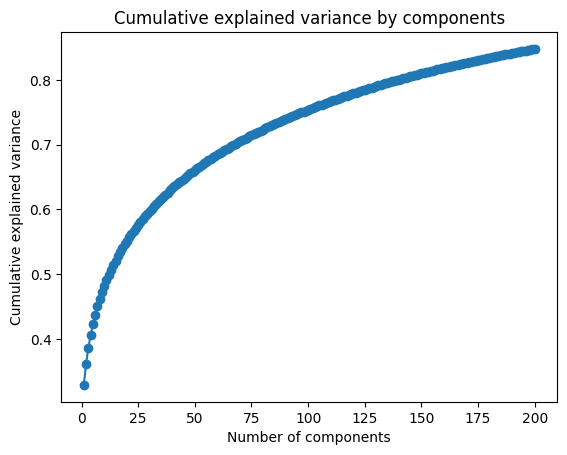

In [22]:
#Scaling the data:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(vectorized_df)

#Setting the number of components:
n_components = 200

#Apply PCA:
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(scaled_data)

explained_variance = pca.explained_variance_ratio_
print("Variance explained by each component:", explained_variance)

# Explained variance graphic to support the number of components selection:
plt.plot(range(1, n_components + 1), explained_variance.cumsum(), marker='o')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('Cumulative explained variance by components')
plt.show()

# 5. Data Split - Train and Test Splits:

## 5.1. Adding the diagnosis (target) to the DataFrame:

In [ ]:
# In our phenotypic "2" means that the DX is negative, therefore we replace it by 0:
pheno_df['DX_GROUP'] = pheno_df['DX_GROUP'].replace(2, 0)

pheno_df = pheno_df.reset_index(drop=True)
vectorized_df = vectorized_df.reset_index(drop=True)

# Add the Subject ID and the Diagnosis to the DataFrame:
vectorized_df['subject'] = pheno_df['subject']
vectorized_df['DX_GROUP'] = pheno_df['DX_GROUP']

display(vectorized_df)

,0,1,2,3,4,5,6,7,8,9,...,6662,6663,6664,6665,6666,6667,6668,6669,subject,DX_GROUP
0,0.870813,0.805070,0.693176,0.778252,0.748457,0.844588,0.807095,0.737196,0.855809,0.769672,...,0.282437,-0.273149,0.228345,0.078729,0.017100,0.067529,-0.249568,-0.143400,50005,1
1,0.898271,0.530014,0.458091,0.251550,0.346688,0.300349,0.185360,0.055388,0.668472,0.039961,...,0.215894,0.395081,0.178194,0.047404,0.250613,0.364111,0.231605,0.175845,50006,1
2,0.694720,0.617756,0.640611,0.538903,0.731939,0.856895,0.400831,0.373279,0.515696,0.491006,...,0.663160,0.494288,0.250436,0.096148,-0.088067,0.275448,-0.038101,0.146421,50008,1
3,0.795809,0.704917,0.662008,0.580074,0.641586,0.697295,0.594052,0.528248,0.766270,0.575263,...,0.492290,0.206852,0.149637,0.104935,0.275394,0.167705,0.082875,0.731423,50009,1
4,0.698046,0.339043,0.658891,0.145301,0.412934,0.695916,0.194750,0.218813,0.408388,0.120781,...,0.121002,0.113757,0.132499,0.083765,0.192908,-0.120131,0.284368,0.443524,50010,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
815,0.608603,0.841734,0.548407,0.598860,0.691022,0.756287,0.512149,0.432697,0.604457,0.424698,...,0.439990,0.265809,-0.452533,0.323737,0.301574,0.438263,0.204875,0.497366,51574,1
816,0.781145,0.673924,0.553285,0.574009,0.709194,0.837303,0.436674,0.519944,0.494364,0.510137,...,0.406716,0.572137,-0.124384,-0.132317,0.308735,0.288378,0.383258,0.835765,51576,1
817,0.447159,0.478067,0.250900,0.076704,0.373822,0.664480,0.199131,0.068500,0.126183,0.174924,...,0.698613,0.489151,0.408260,0.340335,0.610982,0.521387,0.231358,0.410172,51581,1
818,0.423467,0.291398,0.000689,-0.106823,0.309935,0.306685,0.121247,0.081313,0.346079,0.270052,...,-0.108152,0.155436,-0.003550,0.074924,-0.230657,-0.037307,0.032230,0.110144,51606,1


## 5.2. Data Suffle

In [ ]:
df_shuffled = vectorized_df.sample(frac=1).reset_index(drop=True)

print("\nShuffled DataFrame:")
print(df_shuffled)

NameError: name 'vectorized_df' is not defined

## 5.3. Split the data in Train (80%) and Test(20%):

In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and test, stratified by DX_GROUP:
train_df, test_df = train_test_split(df_shuffled, test_size=0.2, random_state=42, stratify=df_shuffled['DX_GROUP'])

print(f"Train set shape: {train_df.shape}")
print(f"Train set shape: {test_df.shape}")

Train set shape: (656, 6672)
Train set shape: (164, 6672)


# 6. XGBoost

## 6.1. Preparing the train and data sets for XGBoost:

In [ ]:
# Training Data
X_train = train_df.drop(columns=['subject', 'DX_GROUP'])
y_train = train_df['DX_GROUP']

# Test Data
X_test = test_df.drop(columns=['subject', 'DX_GROUP'])
y_test = test_df['DX_GROUP']

dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)


## 6.2. XGBoost Hyperparameters Optimization and Cross-Validation using RandomizedSearchCV

In [ ]:
# Defining the hyperparameter search space:
param_dist = {
    'n_estimators': np.arange(50, 300, 50),
    'learning_rate': np.linspace(0.05, 0.2, 4),
    'max_depth': np.arange(2, 5, 1),
    'min_child_weight': np.arange(1, 5, 1),
    'subsample': np.linspace(0.6, 0.9, 3),
    'colsample_bytree': np.linspace(0.6, 0.9, 3),
    'alpha': np.linspace(0, 1, 3)
}

# Creating XGBoost Model for Classification_
xgb_model = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss')

# Set RandomizedSearchCV:
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=20,
    scoring='accuracy',  # Métric for the evaluation
    cv=5,  # Number of folds for the Cross-Validation
    verbose=1,
    random_state=42,
    n_jobs=-1  # Use all the available CPU cores
)

# Run the random search:
random_search.fit(X_train, y_train)

# Show the best hiperparametersMostrar los mejores hiperparámetros
print("Best hiperparameters:", random_search.best_params_)

# Evaluate the model with the test set:
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of the test set:", accuracy)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best hiperparameters: {'subsample': 0.9, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.9, 'alpha': 0.0}
Accuracy of the test set: 0.6585365853658537


## 6.3. Metrics





In [ ]:
y_pred_train = best_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred)

print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

Train Accuracy: 1.0
Test Accuracy: 0.6585365853658537


F1 Score: 0.6056338028169014
ROC AUC: 0.6518352059925093
Gini Coefficient: 0.30367041198501865
Confusion Matrix:
[[65 24]
 [32 43]]
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.73      0.70        89
           1       0.64      0.57      0.61        75

    accuracy                           0.66       164
   macro avg       0.66      0.65      0.65       164
weighted avg       0.66      0.66      0.66       164



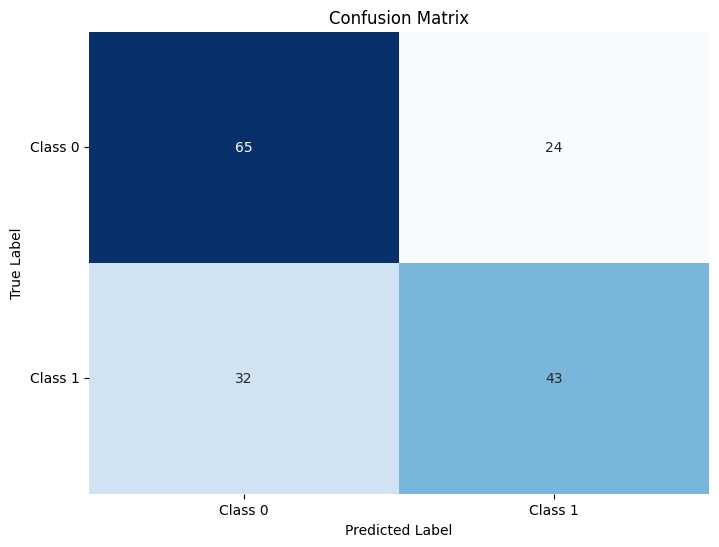

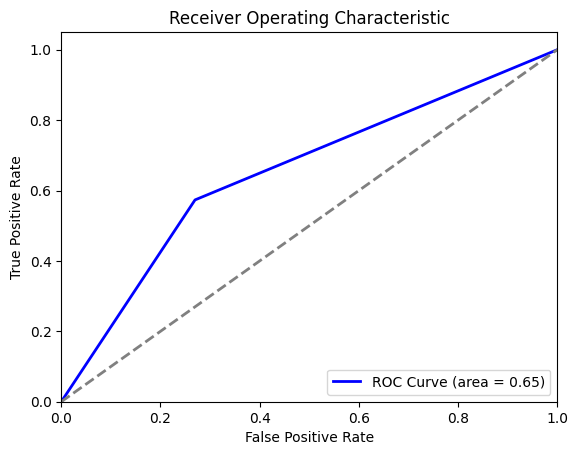

In [ ]:
# Additional Metrics
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
gini = 2 * roc_auc - 1
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'F1 Score: {f1}')
print(f'ROC AUC: {roc_auc}')
print(f'Gini Coefficient: {gini}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{classification_rep}')

# Plotting Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=0)  # Ensure the x-ticks are horizontal
plt.yticks(rotation=0)  # Ensure the y-ticks are horizontal
plt.show()

# Plotting ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

## 6.4. Feature Importance:


TOP 50 Features:
                                  Feature  Importance
3556           Temporal_Mid_L x Caudate_L    0.007823
353              Rectus_R x Frontal_Sup_L    0.007684
3274     Temporal_Sup_R x Cingulum_Post_L    0.007133
2830              Pallidum_R x Fusiform_R    0.006752
616         Cingulum_Post_R x Olfactory_R    0.006529
4589           Cerebelum_4_5_L x Insula_R    0.006377
1480         Fusiform_L x Occipital_Sup_R    0.006241
1765          Parietal_Sup_R x Fusiform_L    0.006207
6576              Vermis_10 x Olfactory_R    0.006136
5335  Cerebelum_8_R x Temporal_Pole_Sup_L    0.005903
3805      Temporal_Pole_Mid_R x Angular_L    0.005478
3076                 Heschl_L x Putamen_R    0.005465
5522      Cerebelum_9_R x SupraMarginal_L    0.005453
4485          Cerebelum_3_R x Olfactory_L    0.005422
6059               Vermis_4_5 x Angular_L    0.005277
369          Rectus_R x Supp_Motor_Area_L    0.005272
3078                Heschl_L x Pallidum_R    0.005174
5500      

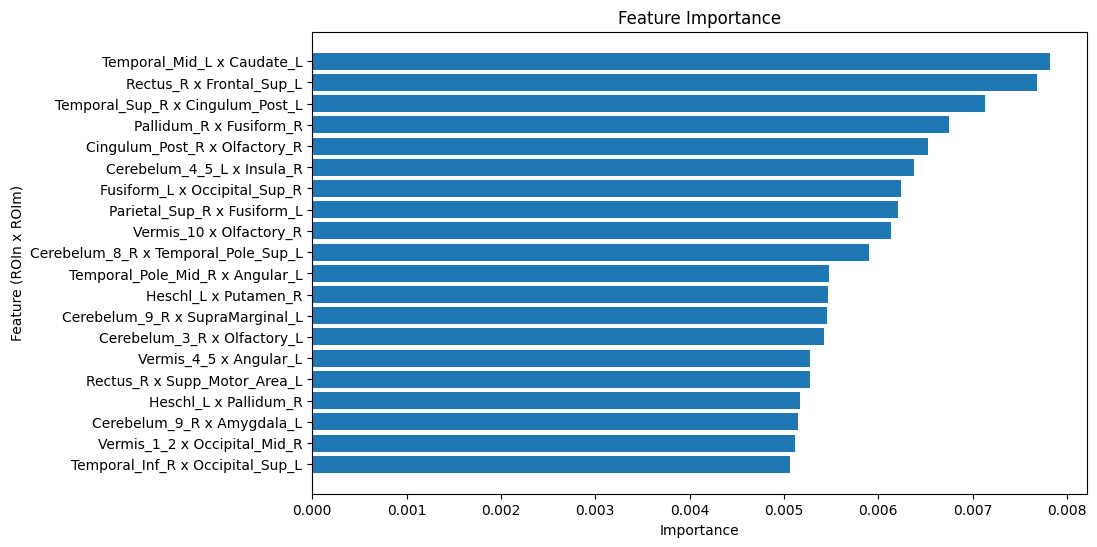

In [ ]:
importances = best_model.feature_importances_
features = vectorized_lower_triangle_labels

# Create a DataFrame to order the features by importance:
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

# Order the DataFrame by importance and select the top 50:
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(20)

# Show the 50 most important features
print("\nTOP 50 Features:")
print(importance_df)

# Visualize the 50 most important features
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature (ROIn x ROIm)')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert Y axis so the most important features are on top
plt.show()

# 7. PCA + XGBoost

In [ ]:
# Scaling the data:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Applying PCA on the training and test data:
X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Defining the hyperparameter search space:
param_dist = {
    'n_estimators': np.arange(50, 300, 50),
    'learning_rate': np.linspace(0.05, 0.2, 4),
    'max_depth': np.arange(2, 5, 1),
    'min_child_weight': np.arange(1, 5, 1),
    'subsample': np.linspace(0.6, 0.9, 3),
    'colsample_bytree': np.linspace(0.6, 0.9, 3),
    'alpha': np.linspace(0, 1, 3)
}

# Creating XGBoost Model for Classification
xgb_model = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss')

# Set RandomizedSearchCV:
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=20,
    scoring='accuracy',  # Métric for the evaluation
    cv=5,  # Number of folds for the Cross-Validation
    verbose=1,
    random_state=42,
    n_jobs=-1  # Use all the available CPU cores
)

# Run the random search:
random_search.fit(X_train_pca, y_train)

# Show the best hiperparameters
print("Best hiperparameters:", random_search.best_params_)

# Evaluate the model with the test set:
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of the test set:", accuracy)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best hiperparameters: {'subsample': 0.75, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bytree': 0.6, 'alpha': 0.0}
Accuracy of the test set: 0.6280487804878049


# 8. Conclusion and acknowledgement

We can conclude that with an accuracy of 0.658, there is significant room for improvement in ADHD diagnosis based on classification models.

Our best metrics are achieved using XGBoost with Hyperparameters Optimization and Cross-Validation using RandomizedSearchCV:

> ACC = 0.658


Despite PCA helped us to reduce the dimensionality of our features, when combined with XGBoost the perfomance was lower:

> ACC = 0.628


There are many ways to expand and improve this project, and we are excited to explore them.

Finally, we would like to express our gratitude to our teaching assistants from Humai, Buenos Aires, who have supported us from day one and generously shared their diverse expertise in neuroscience and computer science.